# Mitigation Bias 

The objective of this notebook is to characterize the bias that is introduced in the power spectrum measurement after correcting the density field of quasars for imaging systematic effects.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import nbodykit.lab as nb
from tqdm.notebook import tqdm
from scipy.stats import binned_statistic
from scipy.optimize import minimize


def readpk(filename):
    d = nb.ConvolvedFFTPower.load(filename)
    return (d.poles['k'], d.poles['power_0'].real - d.attrs['shotnoise']) # 

class Spectra:
    
    def __init__(self, cap='NGC', nside='512'):    
        self.cap = cap
        self.nside = nside
        self.path = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
        self.pkname = lambda p, c, m, n, i, ix:f'{p}spectra_{c}_{m}_mainhighz_{n}_v7_{i}_{ix:04d}_main.json'
        
    def read(self, method):
        
        pks = []
        for ix in tqdm(range(1, 1000+1)):
            k0, p0 = readpk(self.pkname(self.path, self.cap, 'knownsystot', self.nside, '0', ix))    
            k1, p1 = readpk(self.pkname(self.path, self.cap,  method, self.nside, '1', ix))    
            pks.append([p0, p1, p1-p0])

        pks = np.array(pks)
        return k0, pks
    
class Fitter:
    
    def __init__(self, k, dp):
        self.k = k
        self.dp = dp

    def model(self, a, k, p=None):
        k2 = k*k
        C = a[0] + a[1]/k + a[2]/k2        
        return C
        
    def loss(self, params, k, dp):
        """ Loss Function """
        res = (dp - self.model(params, k))                   
        ssr = (res*res).mean()
        return ssr
    
    def minimize(self, guess=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]):
#         print('{:8s}:'.format(''), end=' ')
#         for xi in guess:
#             print(f'{xi:12.4f}', end=' ')
#         print('')        
        self.result = minimize(self.loss, guess, args=(self.k, self.dp))   
        
    def unbias(self, k, pk):
        return pk-self.model(ft.result.x, k)        
        
    def plot(self):
        k_ = np.linspace(self.k.min(), self.k.max(), 500)
        
        plt.scatter(self.k, self.dp, marker='o', label='Measured', alpha=0.5)
        plt.plot(k_, self.model(self.result.x, k_), '--', label='Model')
        plt.ylabel(r'$\Delta$P [Mpc/h]$^{3}$')
        plt.xlabel('k [h/Mpc]')
        plt.legend()
        plt.xscale('log')

## read spectra

In [2]:
sp = Spectra(cap='NGC', nside='512')
k, pknn = sp.read('known')
pknn.shape

(1000, 3, 128)

## Ratios

In [3]:
def solve(x, y):
    n = len(x)
    sumy = np.sum(y)
    sumx = np.sum(x)
    sumx2 = np.sum(x*x)
    sumxy = np.sum(x*y)

    b = (sumy*sumx2-sumx*sumxy)/(n*sumx2-sumx*sumx)
    m = (n*sumxy - sumx*sumy)/(n*sumx2-sumx*sumx)
    return m, b

0.9284187432992339 17764.19612486808
0.39811570964157167 -7260.124091653844
0.32435727819723975 -9137.880238897467
0.272156523077944 -8632.163090473441
0.26843470408263254 -9570.54447192081
0.2515861507861507 -9582.635725758548



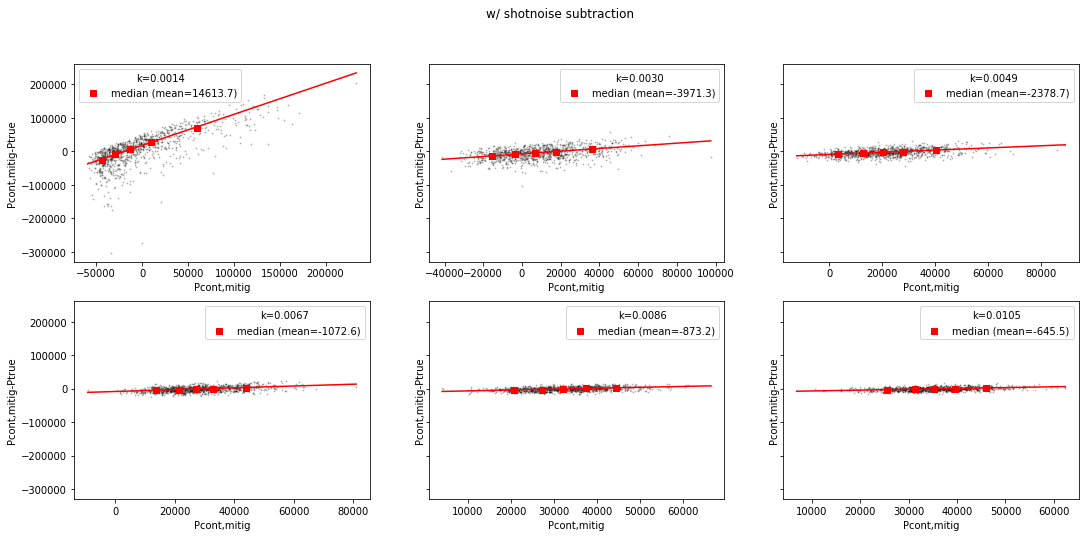

In [4]:
vs = 1

xlabel = {0:'Ptrue',
          1:'Pcont,mitig'}

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), sharey=True)
ax = ax.flatten()
fig.suptitle('w/ shotnoise subtraction')

ms = []
bs = []

for j in tqdm(range(pknn.shape[2])):

    bins_p = np.percentile(pknn[:, vs, j], [0, 20, 40, 60, 80, 100])
    bins_p[-1] += 1.0e-4
    ix = np.digitize(pknn[:, vs, j], bins=bins_p)
    x_ = []
    y_ = []
    for i in ix:
        s_i = ix == i
        x_.append(np.median(pknn[s_i, vs, j], axis=0))
        y_.append(np.median(pknn[s_i, 2, j], axis=0))

    x_ = np.array(x_)
    y_ = np.array(y_)
    
    m,b  = solve(x_, y_)
    
    ms.append(m)
    bs.append(b)
    
    if j < 6:    
        ax[j].scatter(pknn[:, vs, j], pknn[:, 2, j], 1.0, color='k', alpha=0.2)
        ax[j].scatter(x_, y_, label=f'median (mean=%.1f)'%np.mean(y_), marker='s', color='r')
        ax[j].plot(bins_p, m*bins_p + b, 'r-')
        print(m, b)

        #ax[j].set(ylim=(0., 4), xlabel=xlabel[vs], ylabel='Pcont,mitig/Ptrue')
        ax[j].set(xlabel=xlabel[vs], ylabel='Pcont,mitig-Ptrue')#ylim=(0., 10),
        ax[j].legend(title=f'k={k[j]:.4f}')

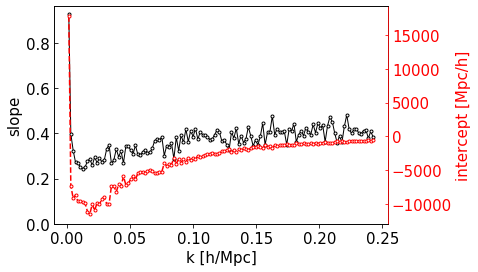

In [5]:
fontsize = 15

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(k, ms, 'k-', marker='.', mfc='w', lw=1)
ax2.plot(k, bs, 'r--', marker='.', mfc='w', )


ax1.set_ylabel(r'slope', fontsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize, direction='in')
ax1.tick_params(axis='x', labelsize=fontsize) # x- has a different color
ax1.set_xlabel('k [h/Mpc]', fontsize=fontsize)
ax1.set_ylim(ymin=0.0)

ax2.set_ylabel(r'intercept [Mpc/h]', fontsize=fontsize, color='r')
ax2.tick_params(axis='y', labelsize=fontsize, direction='in', colors='red', which='both')
ax2.spines['right'].set_color('red')
# ax2.set_xscale('log')

In [6]:
good = k > 0.0015

Ptrue_mean = pknn[:,0,good].mean(axis=0)
Pmitig_mean = pknn[:,1,good].mean(axis=0)

In [9]:
good.sum()

127

In [11]:
ms = np.array(ms)
bs = np.array(bs)

In [21]:
Pcorrec = (1-ms)*pknn[:, 1,:]-bs

Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

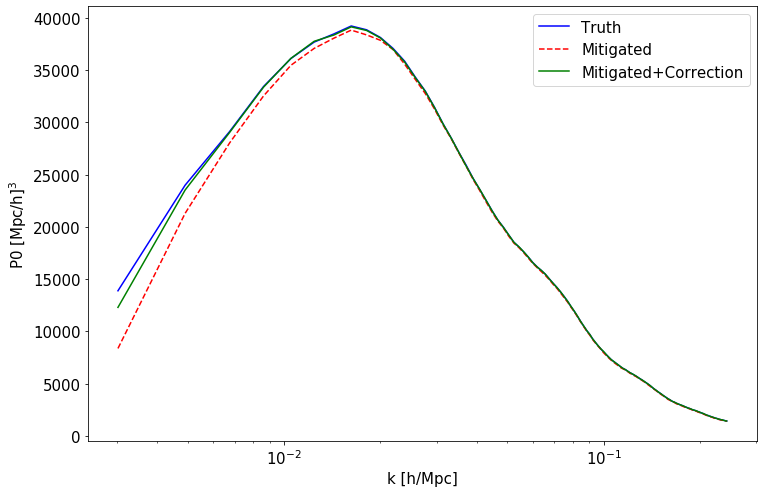

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(k[good], Ptrue_mean, 'b-',
        k[good], Pmitig_mean, 'r--',
        k[good], Pcorrec[:, good].mean(axis=0), 'g-')
plt.legend(['Truth', 'Mitigated', 'Mitigated+Correction'])
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
# plt.yscale('log')

Text(0, 0.5, 'P0/Ptruth')

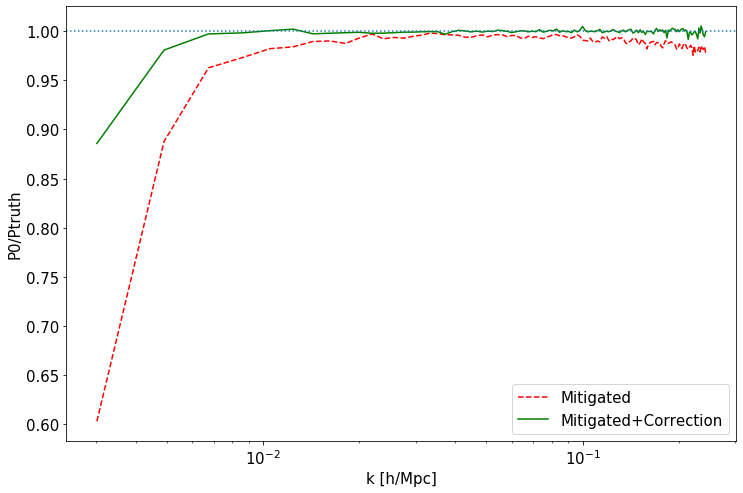

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(
        k[good], Pmitig_mean/Ptrue_mean, 'r--',
        k[good], Pcorrec[:, good].mean(axis=0)/Ptrue_mean, 'g-')
plt.axhline(1.0, ls=':')
plt.legend(['Mitigated', 'Mitigated+Correction'])
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0/Ptruth')
# plt.yscale('log')

Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

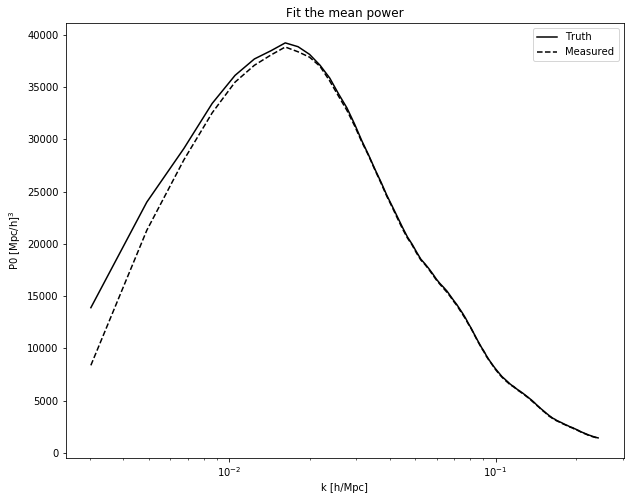

In [31]:
good = k > 0.0015
plt.figure(figsize=(10, 8))
plt.plot(k[good], pknn[:,0,good].mean(axis=0), 'k-',
         k[good], pknn[:,1,good].mean(axis=0), 'k--')
#          k[good], ft.unbias(k[good], pknn[:,1,good].mean(axis=0)), 'r-')

plt.legend(['Truth', 
            'Measured', 
            'Measured + Correction'])
plt.title('Fit the mean power')
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
# plt.savefig('pmean_unbias.png', dpi=300, bbox_inches='tight')

## Fit three groups

In [3]:
def run(seed):
    
    # digitize the spectra
    nparam = 3
    ik = 1
    bins_p = np.percentile(pknn[:, 0, ik], [0, 33.3, 66.6, 100])
    bins_p[-1] = bins_p[-1]+1.0e-5
    bins_c = 0.5*(bins_p[1:]+bins_p[:-1])
    
    #print(bins_p)
    indices = np.digitize(pknn[:, 0, ik], bins_p)

    good = k > 0.0015
    k_ = np.linspace(0.99*k[good].min(), 1.01*k[good].max(), 500)

    print('{:8s}'.format('Sample'), end=' ')
    for xi in range(nparam):
        stri = f'       a[{xi}]'
        print(f'{stri:12s}', end=' ')
    print('')

    mk = {1:'o', 
          2:'s', 
          3:'^'}
    cl = {1:'b',
          2:'orange', 
          3:'g'}
    
    for index in [1, 2, 3]:
        np.random.seed(seed)
        

        sample_i = (indices == index)

        ft = Fitter(k[good], pknn[sample_i][:, 2, good].mean(axis=0))
        ft.minimize(np.random.random(size=nparam))
        
        print('{:8s}:'.format('Sample-%d'%index), end=' ')
        for xi in ft.result.x:
            print(f'{xi:12.4f}', end=' ')
        print('')

        plt.scatter(ft.k, ft.dp, marker=mk[index], label=f'Sample-{index}(P ~ {bins_c[index-1]:.1e})', alpha=0.8)
        plt.plot(k_, ft.model(ft.result.x, k_), '--')


    plt.ylabel(r'$\Delta$P [Mpc/h]$^{3}$', fontsize=15)
    plt.xlabel('k [h/Mpc]', fontsize=15)
    plt.xscale('log')
    plt.xlim(2.0e-3, 3.0e-1)
    _ = plt.legend(fontsize=15)

Sample          a[0]         a[1]         a[2]  
Sample-1:      45.6141      -3.8000      -0.0256 
Sample-2:       0.9722       1.1927      -0.0827 
Sample-3:    -120.8183      13.6005      -0.1845 


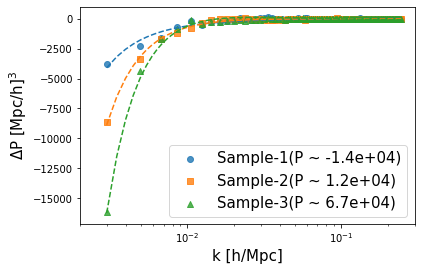

In [4]:
run(42)

Sample          a[0]         a[1]         a[2]  
Sample-1:      45.6138      -3.8000      -0.0256 
Sample-2:       0.9723       1.1927      -0.0827 
Sample-3:    -120.8184      13.6005      -0.1845 


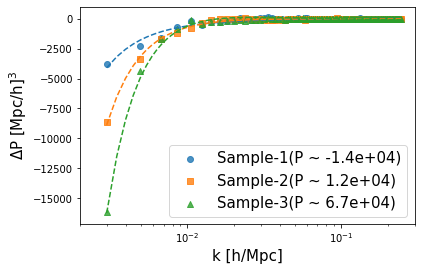

In [5]:
run(98765)

## Fit the mean $\Delta$P

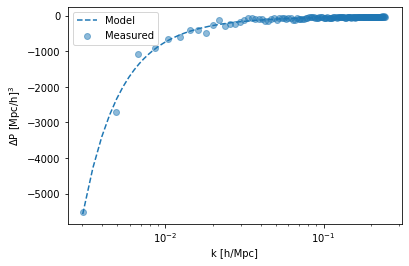

In [14]:
good = k > 0.0015
ft = Fitter(k[good], pknn[:, 2, good].mean(axis=0))
ft.minimize([0.01 for _ in range(4)])
ft.plot()
plt.savefig('deltaP_meanmocks.png', dpi=300, bbox_inches='tight')

In [15]:
ft.result.x

array([-1.81998323e+01, -3.14228943e+00, -4.10594724e-02,  1.00000000e-02])

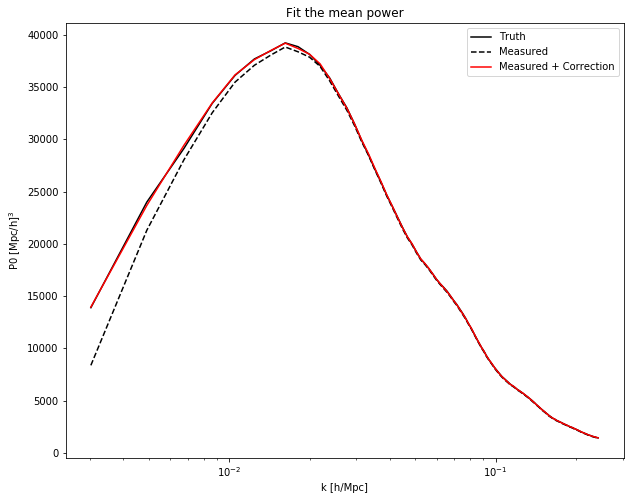

In [16]:
good = k > 0.0015

plt.figure(figsize=(10, 8))
plt.plot(k[good], pknn[:,0,good].mean(axis=0), 'k-',
         k[good], pknn[:,1,good].mean(axis=0), 'k--',
         k[good], ft.unbias(k[good], pknn[:,1,good].mean(axis=0)), 'r-')

plt.legend(['Truth', 
            'Measured', 
            'Measured + Correction'])
plt.title('Fit the mean power')
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
plt.savefig('pmean_unbias.png', dpi=300, bbox_inches='tight')

## Fit the scatter $\Delta$P

In [7]:
good = k > 0.0015
ft1 = Fitter(k[good], pknn[:, 2, good])
ft1.minimize([0.01 for _ in range(10)])

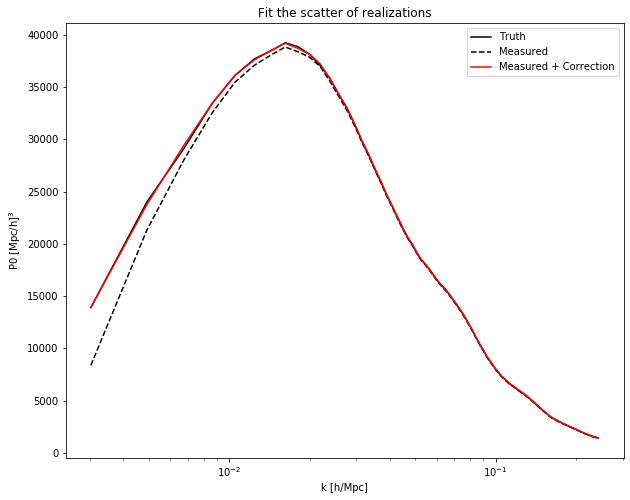

In [8]:
good = k > 0.0015
plt.figure(figsize=(10, 8))
plt.plot(k[good], pknn[:,0,good].mean(axis=0), 'k-',
         k[good], pknn[:,1,good].mean(axis=0), 'k--',
         k[good], ft1.unbias(k[good], pknn[:,1,good].mean(axis=0)), 'r-')

plt.title('Fit the scatter of realizations')
plt.legend(['Truth', 
            'Measured', 
            'Measured + Correction'])
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
plt.savefig('pscatter_unbias.png', dpi=300, bbox_inches='tight')

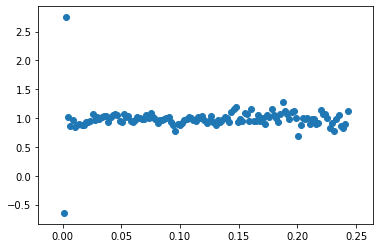

In [74]:
#plt.scatter(pknn[:, , 10], pknn[:, 1, 10], 1.)
plt.scatter(k, pknn[0, 1, :])

In [78]:
ft.result

      fun: 3.740201724659329
 hess_inv: array([[ 6.99008381e-02, -2.15219905e+00,  1.75833192e+01,
        -4.19109307e+01],
       [-2.15219905e+00,  8.49908621e+01, -7.73271237e+02,
         1.95846391e+03],
       [ 1.75833192e+01, -7.73271237e+02,  7.48318409e+03,
        -1.97175543e+04],
       [-4.19109307e+01,  1.95846391e+03, -1.97175543e+04,
         5.34120804e+04]])
      jac: array([1.99675560e-06, 1.49011612e-07, 2.98023224e-08, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 228
      nit: 37
     njev: 38
   status: 0
  success: True
        x: array([   1.18659762,   -6.94116915,   62.59916631, -160.55869765])

In [79]:
ft.dp.shape

(127,)

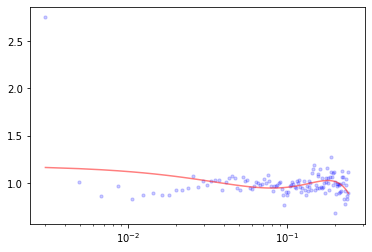

In [80]:
# for i in range(ft.dp.shape[0]):
plt.scatter(ft.k, ft.dp, 10, alpha=0.2, color='b')
    
plt.plot(ft.k, ft.model(ft.result.x, ft.k), alpha=0.5, color='r')
plt.xscale('log')

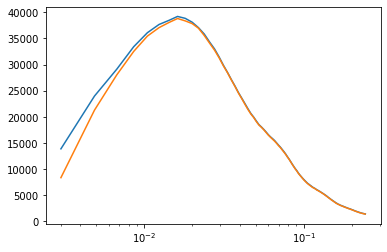

In [82]:
plt.plot(k[good], pknn[:, 0, good].mean(axis=0))
plt.plot(k[good], (pknn[:, 0, good]*pknn[:, 1, good]).mean(axis=0))
# plt.plot(k[good], (pknn[:, 0, good]*pknn[:, 1, good]).mean(axis=0)*ft.model(ft.result.x, ft.k))
plt.xscale('log')

In [4]:
pks = []

for ix in tqdm(range(1, 1000+1)):
    k0, p0 = readpk(pkname(path, cap, 'knownsystot', nside, '0', ix))    
    k1, p1 = readpk(pkname(path, cap, 'knownsystot', nside, '1', ix))    
    k2, p2 = readpk(pkname(path, cap, 'known', nside, '1', ix))        
    
    pks.append([p0, p1, p2])
    
pks = np.array(pks)*1.0e-4
pks.shape

(1000, 3, 128)

In [5]:
pks.shape

(1000, 3, 128)

In [11]:
from scipy.stats import pearsonr

yx = 0
def scatter(ax, x, y, **kw):
    global yx
    pcc = pearsonr(x, y)    
    bc,_,bid = binned_statistic(x, x, statistic='mean')      
    
    rmead = []
    rmin = []
    rmax = []
    for bid_id  in range(bc.size):
        good = bid == bid_id+1
        if good.sum() == 0:
            rmin.append(np.nan)
            rmax.append(np.nan) 
            rmead.append(np.nan)
            continue
        rmin_, rmead_, rmax_ = np.percentile(y[good], [15.9, 50, 84.1]) # 1 sig.
        rmead.append(rmead_)
        rmin.append(rmin_)        
        rmax.append(rmax_)
        
    rmin = np.array(rmin)
    rmax = np.array(rmax)
    rmead = np.array(rmead)
    
    ax.scatter(x, y, 5, **kw)
    ax.errorbar(bc, rmead, yerr=[rmead-rmin, rmax-rmead], 
                color=kw['c'], mfc='w', marker='o', capsize=3)
    #ax.fill_between(bc, rmean-abs(r-rmin), r+abs(rmax-r), color=kw['c'], alpha=0.1)
    
    ax.text(0.7, 0.1-yx*0.05, f'PCC={pcc[0]:.3f}', color=kw['c'], transform=ax.transAxes)
    
    yx += 1 

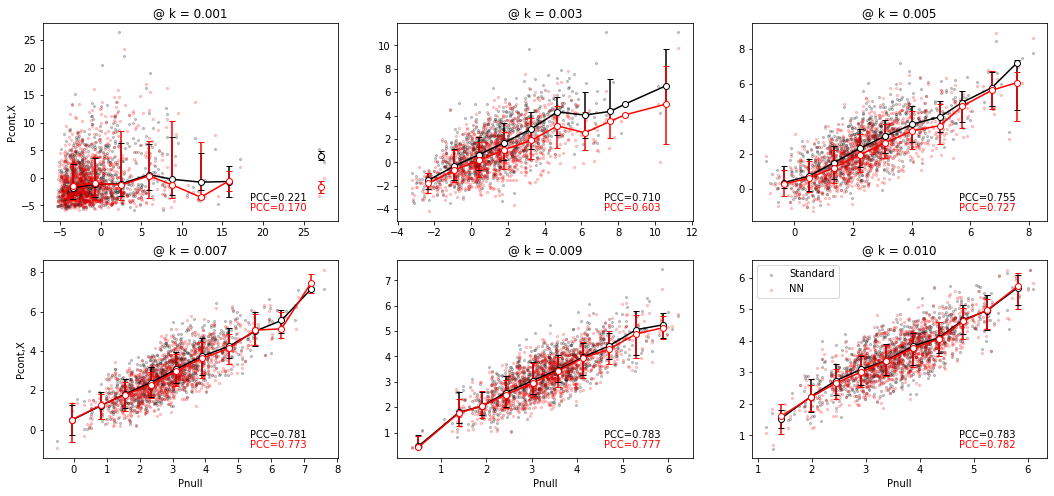

In [12]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X')    

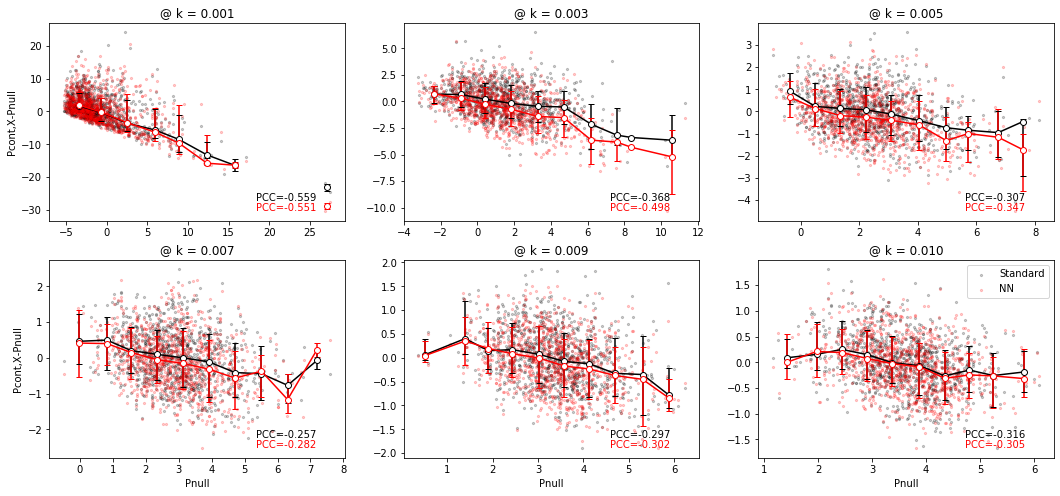

In [13]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix]-pks[:, 0, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix]-pks[:, 0, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X-Pnull')

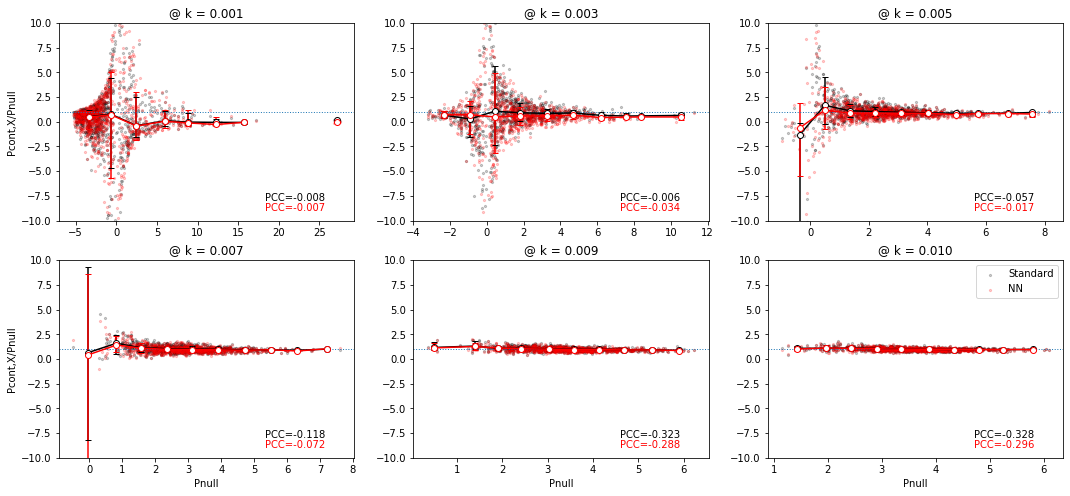

In [16]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix]/pks[:, 0, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix]/pks[:, 0, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    ax[i].axhline(1, ls=':', lw=1)
    ax[i].set_ylim(-10, 10)
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X/Pnull')

In [36]:
dp = {'standard':[], 'nnknown':[]}

for ix in tqdm(range(1, 1000+1)):
    k0, p0 = readpk(pkname(path, cap, 'knownsystot', nside, '0', ix))    
    k1, p1 = readpk(pkname(path, cap, 'knownsystot', nside, '1', ix))    
    k2, p2 = readpk(pkname(path, cap, 'known', nside, '1', ix))        
    
    dp['standard'].append([p0, p1-p0])
    dp['nnknown'].append([p0, p2-p0])
    
dpc = {}
for n,v in dp.items():
    dpc[n] = np.array(v)*1.0e-4  

In [6]:
plt.rc('font', size=18)

Text(0.5, 1.0, 'w/ shotnoise subtraction')

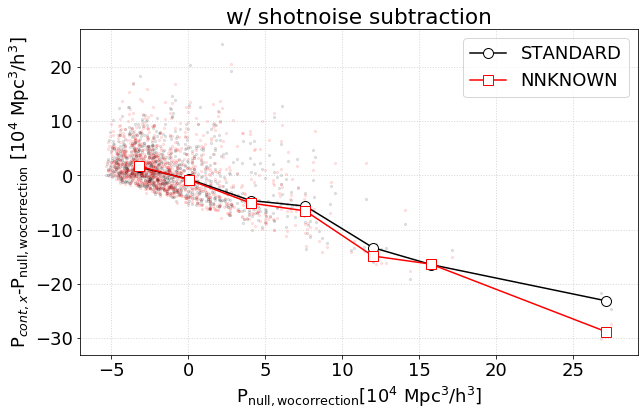

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(-5.5, 30., num=10)

colors = ['k', 'red']
markers = ['o', 's']

for i, (n, v) in enumerate(dpc.items()):
    r,_,_ = binned_statistic(v[:, 0], v[:, 1], 
                             statistic='median', bins=bins)  
    bc,_,_ = binned_statistic(v[:, 0], v[:, 0], 
                             statistic='mean', bins=bins)  
    #std,_,_ = binned_statistic(v[:, 0], v[:, 1], 
    #                         statistic='std', bins=bins)  
    #nm,_,_ = binned_statistic(v[:, 0], np.ones(v.shape[0]), 
    #                         statistic='count', bins=bins)      
    
    ax.scatter(v[:, 0], v[:,1], 5, color=colors[i], alpha=0.1)    
    msk = np.isfinite(r)
    ax.plot(bc[msk], r[msk],
            marker=markers[i], color=colors[i], mfc='w', 
            label=n.upper(), ms=10)
    
ax.grid(lw=1, alpha=0.5, ls=':')  
ax.set(xlabel=r'P$_{{\rm null, wo correction}}$[10$^{4}$ Mpc$^{3}$/h$^{3}$]', 
       ylabel=r'P$_{cont, x}$-P$_{{\rm null, wo correction}}$ [10$^{4}$ Mpc$^{3}$/h$^{3}$]')
ax.legend()
ax.set_title('w/ shotnoise subtraction')

In [37]:
np.percentile(dpc['nnknown'][:, 0], [0, 100])

array([-5.30924267, 27.48701987])

Text(0.5, 1.0, 'w shotnoise subtraction at k=0.0014')

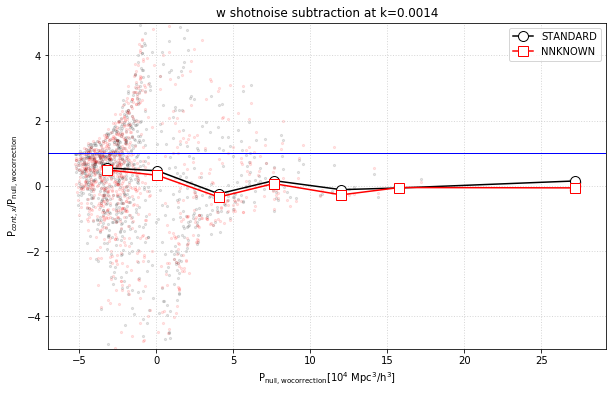

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(-5.5, 30., num=10)
#bins = np.linspace(-1, 1.)
# bins = np.linspace(-4, 12.)

colors = ['k', 'red']
markers = ['o', 's']

for i, (n, v) in enumerate(dpc.items()):
    r,_,_ = binned_statistic(v[:, 0], (v[:, 1]+v[:, 0])/v[:, 0], 
                             statistic='median', bins=bins)  
#     r1,_,_ = binned_statistic(v[:, 0], (v[:, 1]+v[:, 0])/v[:, 0], 
#                              statistic='mean', bins=bins)      
    bc,_,_ = binned_statistic(v[:, 0], v[:, 0], 
                             statistic='mean', bins=bins)  
    #std,_,_ = binned_statistic(v[:, 0], v[:, 1], 
    #                         statistic='std', bins=bins)  
    #nm,_,_ = binned_statistic(v[:, 0], np.ones(v.shape[0]), 
    #                         statistic='count', bins=bins)      
    
    ax.scatter(v[:, 0], v[:, 1]/v[:, 0]+1.0, 5, color=colors[i], alpha=0.1)    
    msk = np.isfinite(r)
    ax.plot(bc[msk], r[msk],
            marker=markers[i], color=colors[i], mfc='w', 
            label=n.upper(), ms=10)
    #ax.plot(bc[msk], r1[msk],
    #        marker=markers[i], color=colors[i], mfc='w', ms=10, ls='--')

ax.axhline(1., ls='-', lw=1, color='b')    
    
ax.grid(lw=1, alpha=0.5, ls=':')  
ax.set(xlabel=r'P$_{{\rm null, wo correction}}$[10$^{4}$ Mpc$^{3}$/h$^{3}$]', 
       ylabel=r'P$_{cont, x}$/P$_{{\rm null, wo correction}}$') # [10$^{4}$ Mpc$^{3}$/h$^{3}$]
ax.set(ylim=(-5., 5.))

ax.legend()
ax.set_title(f'w shotnoise subtraction at k={k0:.4f}')